In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#Load python libraries
import copy
import numpy as np
import glob
import os,sys
# Import Python Libraries
import iris
import iris.plot as iplt
from iris.analysis import MEAN, MAX, SUM
import matplotlib
matplotlib.pyplot.switch_backend('agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%matplotlib inline
acpc_workspace='/group_workspaces/jasmin2/acpc'
acpc_workspace='/gws/nopw/j04/acpc'
#sys.path.append(os.path.join(acpc_workspace,'houston_deep_convection/Intercomparison/acpc_intercomparison'))
sys.path.append('/home/users/pmarinescu/acpc_intercomparison')
sys.path.append('/home/users/pmarinescu')
from acpc_intercomparison_3 import load_variable_cube,color,variable_names,directory,filename
#from Setup_intercomparison import load_variable_cube,color,variable_names,directory,filename
from collections import defaultdict, OrderedDict
f = lambda: defaultdict(f) 

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore')


OrderedDict([('WRF_OXF', OrderedDict([('AccumPrecip', 'RAINNC'), ('OLR', 'OLR'), ('W', 'W'), ('T', 'air_temperature'), ('P', 'air_pressure'), ('rho', 'RHO'), ('U', 'U'), ('V', 'V'), ('QV', 'QVAPOR'), ('LH', 'LHRTOT'), ('QCLD', 'QCLOUD'), ('QRAIN', 'QRAIN'), ('QICE', 'QICE'), ('QSNOW', 'QSNOW'), ('QGRA', 'QGRAUP'), ('NCLD', 'QNCLOUD'), ('NRAIN', 'QNRAIN'), ('NICE', 'QNICE'), ('NSNOW', 'QNSNOW'), ('NGRA', 'QNGRAUPEL'), ('NAERO', 'NAER1'), ('QCOND', 'PCC'), ('QDEP', ''), ('QCNUC', ''), ('QINUC', 'MNUCCD'), ('liquid_hydrometeors', ['QCLOUD', 'QRAIN']), ('ice_hydrometeors', ['QICE', 'QSNOW', 'QGRAUP']), ('hydrometeors', ['QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP'])])), ('WRF_NASA', OrderedDict([('AccumPrecip', 'RAINNC'), ('OLR', 'TLWUP'), ('W', 'W'), ('T', 'air_temperature'), ('P', 'air_pressure'), ('rho', 'RHO'), ('U', 'U'), ('V', 'V'), ('QV', 'QVAPOR'), ('LH', 'LATHEAT'), ('QCLD', 'QCLOUD'), ('QRAIN', 'QRAIN'), ('QICE', 'QICE'), ('QSNOW', 'QSNOW'), ('QGRA', 'QGRAUP'), ('NCLD', 'QNCLOUD'

In [3]:
#plotdir=os.path.join(acpc_workspace,'public/acpc/pmarin','Plots_Apr2020')
#os.makedirs(plotdir,exist_ok=True)

savedir=os.path.join(acpc_workspace,'houston_deep_convection/Processing','Save_2024')
os.makedirs(savedir,exist_ok=True)


In [4]:
models=[]
models.append('COSMO_KIT')
models.append('ICON')
models.append('MesoNH_Toulouse')
models.append('RAMS_CSU')
models.append('UM_LEEDS')
models.append('WRF_NASA')
models.append('WRF_OXF')
models.append('WRF_PNNL')

cases=[]
cases.append('POL')
cases.append('CLN')

modelnames=[]
modelnames.append('COSMO')
modelnames.append('ICON')
modelnames.append('MesoNH')
modelnames.append('RAMS')
modelnames.append('UM')
modelnames.append('NU-WRF')
modelnames.append('WRF-Morr')
modelnames.append('WRF-SBM')

casenames=[]
casenames.append('High-Aero')
casenames.append('Low-Aero')


In [5]:
# Load in ICON data from other location
# This model was added later, and not incoporated into the acpc_intercomparison functions
def call_ICON_mean_profile(vname, case, thr):

    import pickle
    savepath = '/gws/nopw/j04/acpc/users/pmarin/ICON_Profs_2/'
#    thr = 1e-05
#    vname = 'qr'
    #print('ICON'+case)
    msum_prof = np.zeros(95)
    csum_prof = np.zeros(95)
    for t in np.arange(48,193):
#        filename = 'BC_ICON_'+case+'_'+vname+'_tc'+str(thr)+str(t)+'_prof.p'
        filename = 'BC_ICON_'+case+'_'+vname+'_q_now'+str(thr)+str(t)+'_prof.p'
        [prof,cntprof,AGL_profmid] = pickle.load(open( savepath+filename, "rb" ) )

        cntprof[np.isnan(prof)] = 0
        prof[np.isnan(prof)] = 0

        msum_prof = msum_prof + (prof*cntprof)
        csum_prof = csum_prof + cntprof
    
    return(msum_prof/csum_prof,csum_prof,AGL_profmid)


In [6]:
# CLOUD Calculations

In [7]:
# Define figure needs
plt.rcParams.update({'font.size': 17})
thresh = ['_qvarp1']
dx = '500m'; dt = '5m'
thr = 0.0001
# Line Styles for Clean and Polluted Cases
ls={}; ls['CLN']='--'; ls['POL']='-'


# Define variable and variabile lables
varnames = ['NCLD','QCLD']
varnamesi = ['nc','qc']
ttl_l0 = ['(a) ','(b) ','(c) ']
ttl_l = ['Cloud Number','Cloud Mass','Cloud Diameter']
ttl_r0 = ['(d) ','(e) ','(f) ']
ttl_2 = ['(g) ','(h) ','(i) ']
ttl_3 = ['(j) ','(k) ','(l) ']

# Setting x and y limits and scaling for the different variables
ylims = [0,12]
xlims_l = [[10000,1e10],[0,2.5],[2,80]]
xlims_r = [[-250,1750],[-50,400],[-100,50]]
xlbls = ['# kg$^{-1}$','g kg$^{-1}$',r"$\mu$m"]
logs = [1,0,1]
scale_factors = [1,1000,1000000] 

# Define variable and variabile lables
#varnames = ['NCLD','QCLD','NRAIN','QRAIN']
#varnamesi = ['nc','qc','nr','qr']
#ttl_l0 = ['(a) ','(b) ','(g) ','(h) ','(c) ','(i) ']
#ttl_l = ['Cloud Number','Cloud Mass','Rain Number','Rain Mass','Cloud Diameter','Rain Diameter']
#ttl_r0 = ['(d) ','(e) ','(j) ','(k) ','(f) ','(l) ']

# Setting x and y limits and scaling for the different variables
#ylims = [0,14]
#xlims_l = [[10000,1e10],[0,2.5],[100,500000],[0,2.5],[2,80],[0.03,5]]
#xlims_r = [[-250,1750],[-50,400],[-100,100],[-100,100],[-100,50],[-50,150]]
#xlbls = ['# kg$^{-1}$','g kg$^{-1}$','# kg$^{-1}$','g kg$^{-1}$',r"$\mu$m",'mm']
#logs = [1,0,1,0,1,1]
#scale_factors = [1,1000,1,1000,1000000,1000] 

# Defining line widths
lws = 1.5
lwl = 3

_qvarp1
v1 0 | v2 0
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
NCLD 1
v1 0 | v2 1
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
QCLD 2
_qvarp1
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
COSMO_KIT
ICON
MesoNH_Toulouse
RAMS_CSU
UM_LEEDS
WRF_NASA
WRF_OXF
WRF_PNNL
0 47
38 38
43 41
39 43


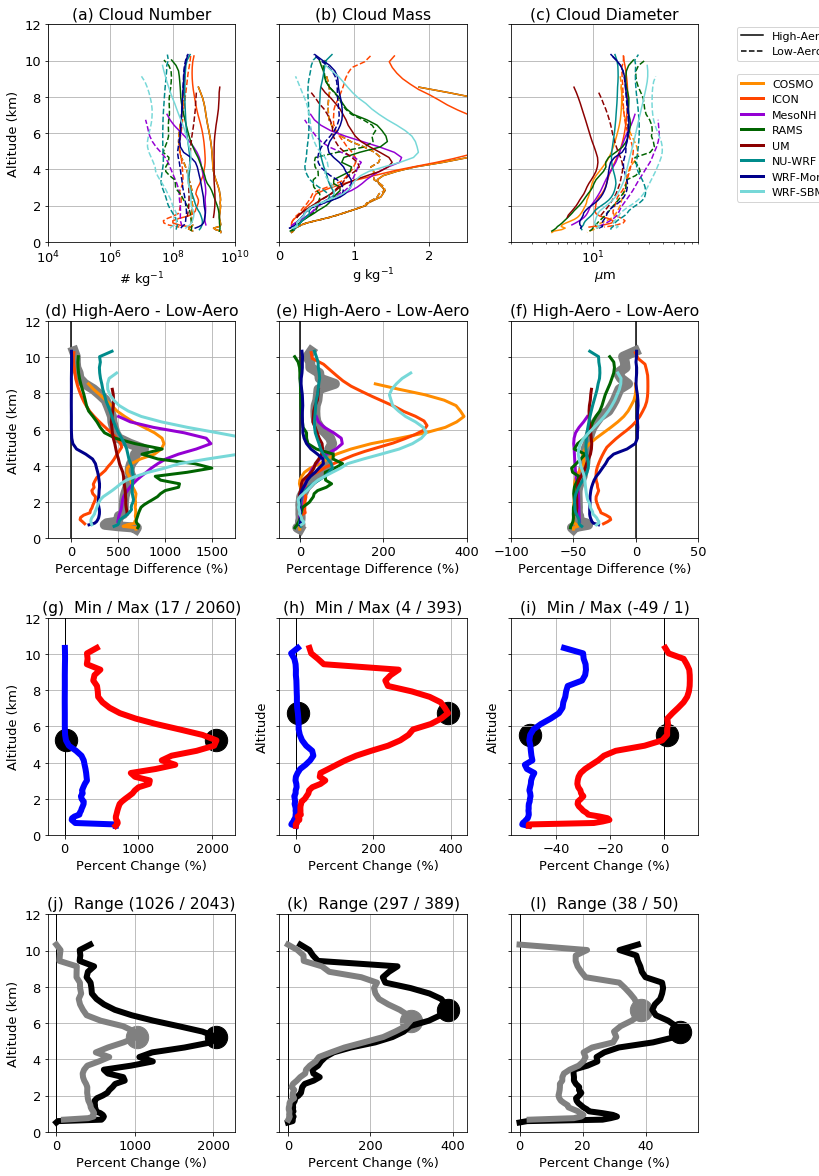

In [11]:
# Cloud Profiles

import numpy.ma as ma

samp_thr = 3000 # Minimum number of grid points

# Define variables for saving model ensemble statistics of Aerosol Effects (Pct Diffs)
temp_arr = ma.masked_array(np.zeros((3,91,len(models))))
min_arr = ma.masked_array(np.zeros((3,91)))
max_arr = ma.masked_array(np.zeros((3,91)))
ran_arr = ma.masked_array(np.zeros((3,91)))
min2_arr = ma.masked_array(np.zeros((3,91)))
max2_arr = ma.masked_array(np.zeros((3,91)))
ran2_arr = ma.masked_array(np.zeros((3,91)))

# Define Figure Size
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(30/2.54,42/2.54))
#fig.subplots_adjust(left=0.05,right=0.97,hspace=0.35,
#                 bottom=0.08,top=0.97,wspace=0.2)
fig.subplots_adjust(top=0.80,hspace=0.4)

##################################################
# Load and plot data for XYT Mean
# Loop through thresholds
##################################################
ii = 0
for i in np.arange(0,len(thresh)):
    print(thresh[i])

    v1 = 0; v2 = 0
    for v in np.arange(0,len(varnames)):
        print('v1 '+str(v1)+' | v2 '+str(v2))
        varname = varnames[v]
        vnamei = varnamesi[v]
        scale_factor = scale_factors[v]
        savedir_i=os.path.join(savedir,varname)
        #print(savedir_i)
        var_xyt_mean={}
        var_xyt_numb={}
        model_hgts={}
        for model in models:
            if model == 'ICON':
                for case in cases:
                    [var_xyt_mean[model,case],var_xyt_numb[model,case],model_hgts[model,case]]=call_ICON_mean_profile(vnamei, case, thr)
            else:
                for case in cases:
                    #print(model,case)
#                    [var_xyt_mean[model,case],var_xyt_numb[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))

                    [var_xyt_mean[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                    [var_xyt_numb[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))

                    model_hgts[model,case] = var_xyt_mean[model,case].coord('geopotential_height').points
                    var_xyt_mean[model,case]=copy.deepcopy(var_xyt_mean[model,case].data)
                    var_xyt_numb[model,case]=copy.deepcopy(var_xyt_numb[model,case].data)
                        
                    #print('Finished loading:',model,case)
                    #print(np.max(var_xyt_mean[model,case]),np.max(var_xyt_numb[model,case]))

            for case in cases:
                var_xyt_mean[model,case][var_xyt_numb[model,case]<=samp_thr] = np.nan
                
        # Loop and Plot
        cnt = 0
        for model in models:
            cntc = 0
            for case in cases:
                print(model,case)
                if cnt == 0:
                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color='k',
                            ls=ls[case],
                            lw=lws,
                            label=f'{casenames[cntc]}')

                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws,
                            label='_no_legend_')                    
                else:
                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws)
                cntc = cntc + 1
            cnt = cnt + 1

        ax[v1,v2].set_xlabel(xlbls[v])
        ax[v1,v2].set_ylim(ylims)
        ax[v1,v2].set_xlim(xlims_l[v])       
        if logs[v] == 1:
            ax[v1,v2].set_xscale('log')
        ax[v1,v2].set_title(ttl_l0[v]+ttl_l[v])

        ##################################################
        # Load and plot data for XYT Mean, no threshold, Absolute Differences and Percentage Differences
        ##################################################
        ax[v1+1,v2].plot([0,0],[0,20],'-k')

        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
           
            # Calculate median and range at each altitude
            if model == 'UM_LEEDS' or model == 'COSMO_KIT' or model == 'ICON':
                var_plot = np.flip(var_plot,axis=0)
            temp_arr[ii,:,cnt] = copy.deepcopy(var_plot[0:91])
                   
            cnt = cnt + 1

        min_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
        max_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
        ran_arr[ii,:] = max_arr[ii,:] - min_arr[ii,:]
            
        ax[v1+1,v2].plot(np.nanmedian(temp_arr[ii,:,:],axis=1),model_hgts[model,case][0:91]/1000.0,
                    color='gray',
                    ms=0,
                    linewidth=10,
                    linestyle='-',
                    label='_no_legend_')
            
        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_pol_n = var_xyt_numb[model,'POL']
            var_cle_n = var_xyt_numb[model,'CLN']           
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
            var_plot[var_pol_n < samp_thr] = np.nan
            var_plot[var_cle_n < samp_thr] = np.nan

            ax[v1+1,v2].plot(var_plot,
                            model_hgts[model,case]/1000.0,
                            color=color[model],
                            ls='-',
                            lw=lwl,
                            label=f'{modelnames[cnt]}')
            cnt = cnt + 1

        #ax.set_xticks(np.arange(-0.006,0.0021,0.002))
        ax[v1+1,v2].set_xlabel('Percentage Difference (%)')
    #    ax[0,1].set_ylabel('Altitude (km)')
        ax[v1+1,v2].set_ylim(ylims)
        ax[v1+1,v2].set_xlim(xlims_r[v])
        #ax[v1+1,v2].set_yticklabels([''])
        ax[v1+1,v2].set_title(ttl_r0[v] +'High-Aero - Low-Aero')

        # Calculate range excluding the min and max values
        for zzz in np.arange(0,91):
            temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == min_arr[ii,zzz]] = np.nan
            temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == max_arr[ii,zzz]] = np.nan
        min2_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
        max2_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
        ran2_arr[ii,:] = max2_arr[ii,:] - min2_arr[ii,:]
        
        
        v2 = v2+1
        if v == 1:
            v1 = 2
            v2 = 0

        ii = ii + 1
        print(varname,ii)
        
        
##################################################
# Load and plot data for XYT Mean
# Loop through thresholds
##################################################
            
# Cloud Diameter Calculation    
v1 = 0; v2 = 2; v = 2
scale_factor = scale_factors[v]
for i in np.arange(0,len(thresh)):
    print(thresh[i])

    savedir_i1=os.path.join(savedir,'NCLD')
    savedir_i2=os.path.join(savedir,'QCLD')
    var_xyt_mean_N={}
    var_xyt_mean_Q={}
    var_xyt_numb_N={}
    var_xyt_numb_Q={}
    for model in models:      
        
        if model == 'ICON':
            for case in cases:
                [var_xyt_mean_N[model,case],var_xyt_numb_N[model,case],model_hgts[model,case]]=call_ICON_mean_profile('nc', case, thr)
                [var_xyt_mean_Q[model,case],var_xyt_numb_Q[model,case],model_hgts[model,case]]=call_ICON_mean_profile('qc', case, thr)
        else:
            for case in cases:
                #print(model,case)
                tempN=iris.load_cube(os.path.join(savedir_i1,f'NCLD_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                tempQ=iris.load_cube(os.path.join(savedir_i2,f'QCLD_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_mean_N[model,case]=tempN.data
                var_xyt_mean_Q[model,case]=tempQ.data

                var_xyt_numb_N[model,case]=iris.load_cube(os.path.join(savedir_i1,f'NCLD_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_numb_Q[model,case]=iris.load_cube(os.path.join(savedir_i2,f'QCLD_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_numb_N[model,case] = var_xyt_numb_N[model,case].data
                var_xyt_numb_Q[model,case] = var_xyt_numb_Q[model,case].data
                
        for case in cases:
            var_xyt_mean_N[model,case][var_xyt_numb_N[model,case]<=samp_thr] = np.nan
            var_xyt_mean_Q[model,case][var_xyt_numb_Q[model,case]<=samp_thr] = np.nan
                
                
        # Calculate mass mean diameter (assuming uniform distribution)
        for case in cases:
            rho_water = 997.0 #kg/m^3
            # Calculate mass mean diameter
            var_xyt_mean[model,case] =  np.power( var_xyt_mean_Q[model,case] / var_xyt_mean_N[model,case] / rho_water * (6.0/np.pi) , 1.0/3.0 )
       
    # Loop and Plot
    cnt = 0
    for model in models:
        cntc = 0
        for case in cases:
            print(model,case)            
            ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                        model_hgts[model,case]/1000.,
                        color=color[model],
                        ls=ls[case],
                        lw=lws,
                        label=f'{modelnames[cnt]} {casenames[cntc]}')
            cntc = cntc + 1
        cnt = cnt + 1

    ax[v1,v2].set_xlabel(xlbls[v])
    #ax[v1,v2].set_ylabel('Altitude (km)')
    ax[v1,v2].set_ylim(ylims)
    ax[v1,v2].set_xlim(xlims_l[v])
    if logs[v] == 1:
        ax[v1,v2].set_xscale('log')
    ax[v1,v2].set_title(ttl_l0[v]+ttl_l[v])
   
    ##################################################
    # Load and plot data for XYT Mean, no threshold, Absolute Differences and Percentage Differences
    ##################################################
    ax[v1+1,v2].plot([0,0],[0,20],'-k') # Add line at x = 0

    cnt = 0; ii = 2
    for model in models:
        print(model)
        var_pol = (var_xyt_mean[model,'POL']*scale_factor) 
        var_cle = (var_xyt_mean[model,'CLN']*scale_factor)
        var_plot = (var_pol-var_cle) / var_cle * 100    # Calculate Percentage Different (High-Low)

        # Calculate median and range at each altitude
        if model == 'UM_LEEDS' or model == 'COSMO_KIT' or model == 'ICON':
            var_plot = np.flip(var_plot,axis=0)

        temp_arr[ii,:,cnt] = var_plot[0:91]
        cnt = cnt + 1

    # Save statistics, min, max, and range of values for all models
    min_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
    max_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
    ran_arr[ii,:] = max_arr[ii,:] - min_arr[ii,:]

    # Plot ensemble median in gray and larger line width
    ax[v1+1,v2].plot(np.nanmedian(temp_arr[ii,:,:],axis=1),model_hgts[model,case][0:91]/1000.0,
                color='gray',
                ms=0,
                linewidth=10,
                linestyle='-',
                label='_no_legend_')

    cnt = 0
    for model in models:
        var_pol = var_xyt_mean[model,'POL']*scale_factor
        var_cle = var_xyt_mean[model,'CLN']*scale_factor
        var_plot = (var_pol-var_cle) / var_cle * 100    
        
        ax[v1+1,v2].plot(var_plot,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls='-',
                            lw=lwl,
                            label=f'{modelnames[cnt]}')
        cnt = cnt + 1

    ax[v1+1,v2].set_xlabel('Percentage Difference (%)')
#    ax[0,1].set_ylabel('Altitude (km)')
    ax[v1+1,v2].set_ylim(ylims)
    ax[v1+1,v2].set_xlim(xlims_r[v])
    ax[v1+1,v2].set_title(ttl_r0[v] +'High-Aero - Low-Aero')
    ax[v1+1,v2].set_yticklabels([''])

    # Calculate range excluding the min and max values
    for zzz in np.arange(0,91):
        temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == min_arr[ii,zzz]] = np.nan
        temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == max_arr[ii,zzz]] = np.nan
    min2_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
    max2_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
    ran2_arr[ii,:] = max2_arr[ii,:] - min2_arr[ii,:]
    

# Define altitude range for finding model ensemble statistics
id0 = 0 #km
id1 = 8 #km
zid0 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id0) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id0)))[0])
zid1 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id1) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id1)))[0])
print(zid0,zid1) # Print Model Levels
    
# Add Min Max Range to all plots    
for i in np.arange(0,3):
    mid = int(np.where(ran_arr[i,zid0:zid1] == np.nanmax(ran_arr[i,zid0:zid1]))[0])
    mid2 = int(np.where(ran2_arr[i,zid0:zid1] == np.nanmax(ran2_arr[i,zid0:zid1]))[0])
    print(mid,mid2)

    lw = 6
    ss = 500
    cs = ['blue','red','black','gray']

    ax[2,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1,c='k')
    ax[2,i].plot(min_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[0])
    ax[2,i].plot(max_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[1])
    ax[2,i].scatter(min_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[2,i].scatter(max_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
#    ax[2,i].set_title('Min / Max ('+str(int(min_arr[i,mid]))+' / '+str(int(max_arr[i,mid]))+')',color=cs[2])
    ax[2,i].set_title(ttl_2[i]+' Min / Max ('+str(int(min_arr[i,mid]))+' / '+str(int(max_arr[i,mid]))+')',color=cs[2])
    ax[2,i].set_ylabel('Altitude')
    ax[2,i].set_xlabel('Percent Change (%)')
    ax[2,i].set_ylim(ylims)
#    ax[0].set_xlim(xlims)

    ax[3,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1,c='k')
    ax[3,i].plot(ran_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[2])
    ax[3,i].scatter(ran_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[3,i].plot(ran2_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[3])
    ax[3,i].scatter(ran2_arr[i,mid2],model_hgts[model,case][mid2]/1000.0,s=ss,c=cs[3])
#    ax[3,i].set_title('Range ('+str(int(ran2_arr[i,mid2]))+' / '+str(int(ran_arr[i,mid]))+')',color=cs[2])
    ax[3,i].set_title(ttl_3[i]+' Range ('+str(int(ran2_arr[i,mid2]))+' / '+str(int(ran_arr[i,mid]))+')',color=cs[2])
    ax[3,i].set_xlabel('Percent Change (%)')
 #   ax[1].set_xlim(xlims2)
    ax[3,i].set_ylim(ylims)
    
# Added gridded lines on all the plots
for i in np.arange(0,4):
    for j in np.arange(0,3):
        ax[i,j].grid()

for i in np.arange(0,4):            
    ax[i,0].set_ylabel('Altitude (km)')
    ax[i,1].set_yticklabels('')
    ax[i,2].set_yticklabels('')
        
#plt.tight_layout()   
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, fontsize=12, loc='lower right',bbox_to_anchor=[0.95,0.06])
#fig.legend(handles, labels, fontsize=14, loc='lower left', ncol=1, bbox_to_anchor=[0.035,0.0])

#handles, labels = ax[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, fontsize=12, loc='lower right',bbox_to_anchor=[0.95,0.43])
#fig.legend(handles, labels, fontsize=14, loc='lower left',ncol=4, bbox_to_anchor=[0.15,0.0])

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.86,0.97])

handles, labels = ax[1,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.86,0.93])


plotdir = '/gws/nopw/j04/acpc/public/pmarin/BAMS/Figs_2024/'
savename = 'PubBC_ACPC_C_cld0.1_Profiles_4x3'+'_samp'+str(int(samp_thr))+'_with_minmaxran'
#fig.tight_layout()
fig.tight_layout(rect=[0,0,0.87,1.0])
fig.savefig(os.path.join(plotdir,savename+'.pdf'),dpi=300)  
fig.savefig(os.path.join(plotdir,savename+'.png'),dpi=300)  
fig.savefig(os.path.join(plotdir,savename+'.eps'),dpi=300)  

In [12]:
# RAIN Calculations

In [13]:
# Define figure needs
plt.rcParams.update({'font.size': 17})
thresh = ['_qvarp1']
dx = '500m'; dt = '5m'
thr = 0.0001
# Line Styles for Clean and Polluted Cases
ls={}; ls['CLN']='--'; ls['POL']='-'

# Define variable and variabile lables
varnames = ['NRAIN','QRAIN']
varnamesi = ['nr','qr']
ttl_l0 = ['(a) ','(b) ','(c) ']
ttl_l = ['Rain Number','Rain Mass','Rain Diameter']
ttl_r0 = ['(d) ','(e) ','(f) ']
ttl_2 = ['(g) ','(h) ','(i) ']
ttl_3 = ['(j) ','(k) ','(l) ']

# Setting x and y limits and scaling for the different variables
ylims = [0,12]
xlims_l = [[100,500000],[0,2.5],[0.03,5]]
xlims_r = [[-100,100],[-100,100],[-50,150]]
xlbls = ['# kg$^{-1}$','g kg$^{-1}$','mm']
logs = [1,0,1]
scale_factors = [1,1000,1000] 

# Defining line widths
lws = 1.5
lwl = 3

_qvarp1
v1 0 | v2 0
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
NRAIN 1
v1 0 | v2 1
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
QRAIN 2
_qvarp1
COSMO_KIT POL
COSMO_KIT CLN
ICON POL
ICON CLN
MesoNH_Toulouse POL
MesoNH_Toulouse CLN
RAMS_CSU POL
RAMS_CSU CLN
UM_LEEDS POL
UM_LEEDS CLN
WRF_NASA POL
WRF_NASA CLN
WRF_OXF POL
WRF_OXF CLN
WRF_PNNL POL
WRF_PNNL CLN
COSMO_KIT
ICON
MesoNH_Toulouse
RAMS_CSU
UM_LEEDS
WRF_NASA
WRF_OXF
WRF_PNNL
0 47
13 27
0 36
27 27


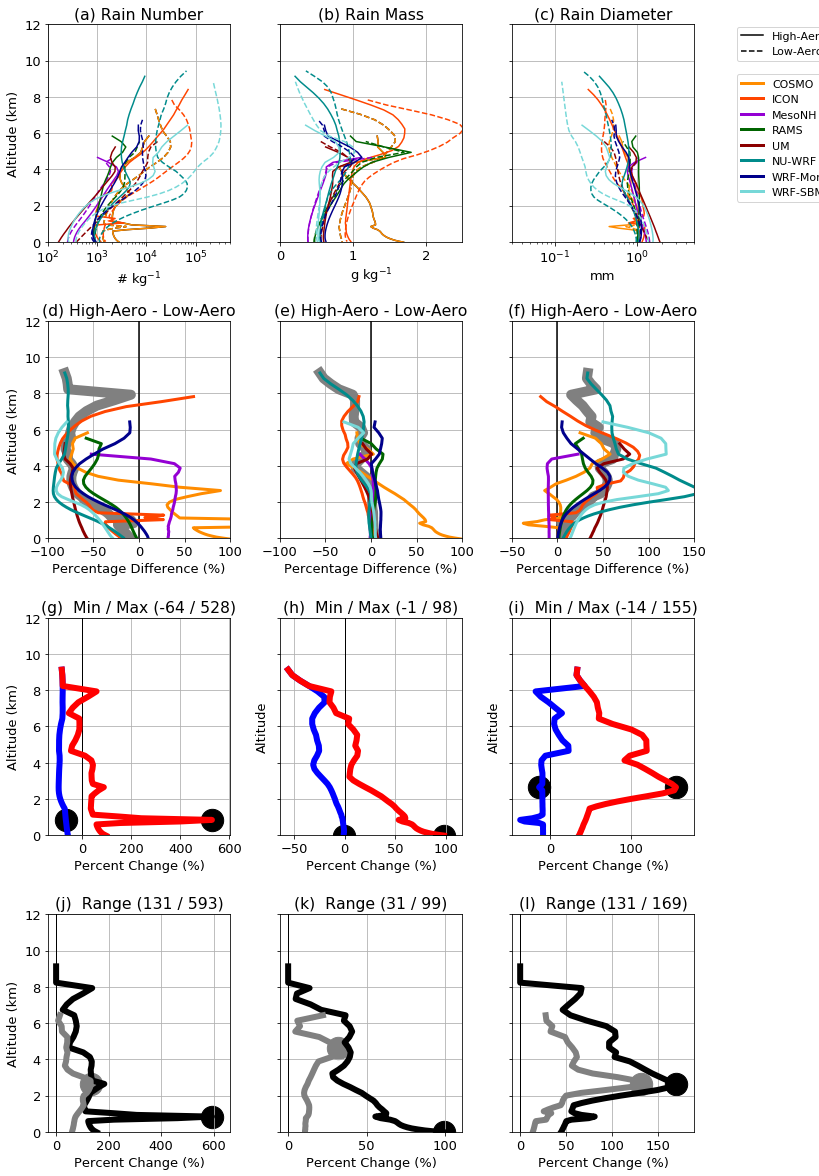

In [14]:
import numpy.ma as ma

samp_thr = 3000 # Minimum number of grid points

# Define variables for saving model ensemble statistics of Aerosol Effects (Pct Diffs)
temp_arr = ma.masked_array(np.zeros((3,91,len(models))))
min_arr = ma.masked_array(np.zeros((3,91)))
max_arr = ma.masked_array(np.zeros((3,91)))
ran_arr = ma.masked_array(np.zeros((3,91)))
min2_arr = ma.masked_array(np.zeros((3,91)))
max2_arr = ma.masked_array(np.zeros((3,91)))
ran2_arr = ma.masked_array(np.zeros((3,91)))

# Define Figure Size
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(nrows=4,ncols=3,figsize=(30/2.54,42/2.54))
fig.subplots_adjust(top=0.80,hspace=0.4)

##################################################
# Load and plot data for XYT Mean
# Loop through thresholds
##################################################
ii = 0
for i in np.arange(0,len(thresh)):
    print(thresh[i])

    v1 = 0; v2 = 0
    for v in np.arange(0,len(varnames)):
        print('v1 '+str(v1)+' | v2 '+str(v2))
        varname = varnames[v]
        vnamei = varnamesi[v]
        scale_factor = scale_factors[v]
        savedir_i=os.path.join(savedir,varname)
        #print(savedir_i)
        var_xyt_mean={}
        var_xyt_numb={}
        model_hgts={}
        for model in models:
            if model == 'ICON':
                for case in cases:
                    [var_xyt_mean[model,case],var_xyt_numb[model,case],model_hgts[model,case]]=call_ICON_mean_profile(vnamei, case, thr)
            else:
                for case in cases:
                    #print(model,case)
#                    [var_xyt_mean[model,case],var_xyt_numb[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))

                    [var_xyt_mean[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                    [var_xyt_numb[model,case]]=iris.load(os.path.join(savedir_i,f'{varname}_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))

                    model_hgts[model,case] = var_xyt_mean[model,case].coord('geopotential_height').points
                    var_xyt_mean[model,case]=copy.deepcopy(var_xyt_mean[model,case].data)
                    var_xyt_numb[model,case]=copy.deepcopy(var_xyt_numb[model,case].data)
                        
                    #print('Finished loading:',model,case)
                    #print(np.max(var_xyt_mean[model,case]),np.max(var_xyt_numb[model,case]))

            for case in cases:
                var_xyt_mean[model,case][var_xyt_numb[model,case]<=samp_thr] = np.nan
        
        # Loop and Plot
        cnt = 0
        for model in models:
            cntc = 0
            for case in cases:
                print(model,case)
                if cnt == 0:
                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color='k',
                            ls=ls[case],
                            lw=lws,
                            label=f'{casenames[cntc]}')

                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws,
                            label='_no_legend_')                    
                else:
                    ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls=ls[case],
                            lw=lws)
                cntc = cntc + 1
            cnt = cnt + 1

        ax[v1,v2].set_xlabel(xlbls[v])
        ax[v1,v2].set_ylim(ylims)
        ax[v1,v2].set_xlim(xlims_l[v])       
        if logs[v] == 1:
            ax[v1,v2].set_xscale('log')
        ax[v1,v2].set_title(ttl_l0[v]+ttl_l[v])

        ##################################################
        # Load and plot data for XYT Mean Percentage Differences
        ##################################################
        ax[v1+1,v2].plot([0,0],[0,20],'-k')

        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
           
            # Calculate median and range at each altitude
            if model == 'UM_LEEDS' or model == 'COSMO_KIT' or model == 'ICON':
                var_plot = np.flip(var_plot,axis=0)
            temp_arr[ii,:,cnt] = copy.deepcopy(var_plot[0:91])
                   
            cnt = cnt + 1

        min_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
        max_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
        ran_arr[ii,:] = max_arr[ii,:] - min_arr[ii,:]
            
        ax[v1+1,v2].plot(np.nanmedian(temp_arr[ii,:,:],axis=1),model_hgts[model,case][0:91]/1000.0,
                    color='gray',
                    ms=0,
                    linewidth=10,
                    linestyle='-',
                    label='_no_legend_')
            
        cnt = 0
        for model in models:
            var_pol = var_xyt_mean[model,'POL']*scale_factor
            var_cle = var_xyt_mean[model,'CLN']*scale_factor
            var_pol_n = var_xyt_numb[model,'POL']
            var_cle_n = var_xyt_numb[model,'CLN']           
            var_plot = (var_pol-var_cle) / var_cle * 100    
            var_plot[var_pol < 0.0001] = np.nan
            var_plot[var_cle < 0.0001] = np.nan
            var_plot[var_pol_n < samp_thr] = np.nan
            var_plot[var_cle_n < samp_thr] = np.nan

            ax[v1+1,v2].plot(var_plot,
                            model_hgts[model,case]/1000.0,
                            color=color[model],
                            ls='-',
                            lw=lwl,
                            label=f'{modelnames[cnt]}')
            cnt = cnt + 1

        #ax.set_xticks(np.arange(-0.006,0.0021,0.002))
        ax[v1+1,v2].set_xlabel('Percentage Difference (%)')
    #    ax[0,1].set_ylabel('Altitude (km)')
        ax[v1+1,v2].set_ylim(ylims)
        ax[v1+1,v2].set_xlim(xlims_r[v])
        #ax[v1+1,v2].set_yticklabels([''])
        ax[v1+1,v2].set_title(ttl_r0[v] +'High-Aero - Low-Aero')

        # Calculate range excluding the min and max values
        for zzz in np.arange(0,91):
            temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == min_arr[ii,zzz]] = np.nan
            temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == max_arr[ii,zzz]] = np.nan
        min2_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
        max2_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
        ran2_arr[ii,:] = max2_arr[ii,:] - min2_arr[ii,:]
        
        
        v2 = v2+1
        if v == 1:
            v1 = 2
            v2 = 0

        ii = ii + 1
        print(varname,ii)
        
        
##################################################
# Load and plot data for XYT Mean
# Loop through thresholds
##################################################
            
# Rain Diameter Calculation    
v1 = 0; v2 = 2; v = 2
scale_factor = scale_factors[v]
for i in np.arange(0,len(thresh)):
    print(thresh[i])

    savedir_i1=os.path.join(savedir,'NRAIN')
    savedir_i2=os.path.join(savedir,'QRAIN')
    var_xyt_mean_N={}
    var_xyt_mean_Q={}
    var_xyt_numb_N={}
    var_xyt_numb_Q={}
    for model in models:      
        
        if model == 'ICON':
            for case in cases:
                [var_xyt_mean_N[model,case],var_xyt_numb_N[model,case],model_hgts[model,case]]=call_ICON_mean_profile('nr', case, thr)
                [var_xyt_mean_Q[model,case],var_xyt_numb_Q[model,case],model_hgts[model,case]]=call_ICON_mean_profile('qr', case, thr)
        else:
            for case in cases:
                #print(model,case)
                tempN=iris.load_cube(os.path.join(savedir_i1,f'NRAIN_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                tempQ=iris.load_cube(os.path.join(savedir_i2,f'QRAIN_xyt_mean_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_mean_N[model,case]=tempN.data
                var_xyt_mean_Q[model,case]=tempQ.data

                var_xyt_numb_N[model,case]=iris.load_cube(os.path.join(savedir_i1,f'NRAIN_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_numb_Q[model,case]=iris.load_cube(os.path.join(savedir_i2,f'QRAIN_xyt_numb_{model}_{case}_{dx}_{dt}{thresh[i]}.nc'))
                var_xyt_numb_N[model,case] = var_xyt_numb_N[model,case].data
                var_xyt_numb_Q[model,case] = var_xyt_numb_Q[model,case].data
                
        for case in cases:
            var_xyt_mean_N[model,case][var_xyt_numb_N[model,case]<=samp_thr] = np.nan
            var_xyt_mean_Q[model,case][var_xyt_numb_Q[model,case]<=samp_thr] = np.nan                
                
        # Calculate mass mean diameter (assuming uniform distribution)
        for case in cases:
            rho_water = 997.0 #kg/m^3
            # Calculate mass mean diameter
            var_xyt_mean[model,case] =  np.power( var_xyt_mean_Q[model,case] / var_xyt_mean_N[model,case] / rho_water * (6.0/np.pi) , 1.0/3.0 )
       
    # Loop and Plot
    cnt = 0
    for model in models:
        cntc = 0
        for case in cases:
            print(model,case)            
            ax[v1,v2].plot(var_xyt_mean[model,case]*scale_factor,
                        model_hgts[model,case]/1000.,
                        color=color[model],
                        ls=ls[case],
                        lw=lws,
                        label=f'{modelnames[cnt]} {casenames[cntc]}')
            cntc = cntc + 1
        cnt = cnt + 1

    ax[v1,v2].set_xlabel(xlbls[v])
    #ax[v1,v2].set_ylabel('Altitude (km)')
    ax[v1,v2].set_ylim(ylims)
    ax[v1,v2].set_xlim(xlims_l[v])
    if logs[v] == 1:
        ax[v1,v2].set_xscale('log')
    ax[v1,v2].set_title(ttl_l0[v]+ttl_l[v])
   
    ##################################################
    # Load and plot data for XYT Mean Percentage Differences
    ##################################################
    ax[v1+1,v2].plot([0,0],[0,20],'-k') # Add line at x = 0

    cnt = 0; ii = 2
    for model in models:
        print(model)
        var_pol = (var_xyt_mean[model,'POL']*scale_factor) 
        var_cle = (var_xyt_mean[model,'CLN']*scale_factor)
        var_plot = (var_pol-var_cle) / var_cle * 100    # Calculate Percentage Different (High-Low)

        # Calculate median and range at each altitude
        if model == 'UM_LEEDS' or model == 'COSMO_KIT' or model == 'ICON':
            var_plot = np.flip(var_plot,axis=0)

        temp_arr[ii,:,cnt] = var_plot[0:91]
        cnt = cnt + 1

    # Save statistics, min, max, and range of values for all models
    min_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
    max_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
    ran_arr[ii,:] = max_arr[ii,:] - min_arr[ii,:]

    # Plot ensemble median in gray and larger line width
    ax[v1+1,v2].plot(np.nanmedian(temp_arr[ii,:,:],axis=1),model_hgts[model,case][0:91]/1000.0,
                color='gray',
                ms=0,
                linewidth=10,
                linestyle='-',
                label='_no_legend_')

    cnt = 0
    for model in models:
        var_pol = var_xyt_mean[model,'POL']*scale_factor
        var_cle = var_xyt_mean[model,'CLN']*scale_factor
        var_plot = (var_pol-var_cle) / var_cle * 100    
        
        ax[v1+1,v2].plot(var_plot,
                            model_hgts[model,case]/1000.,
                            color=color[model],
                            ls='-',
                            lw=lwl,
                            label=f'{modelnames[cnt]}')
        cnt = cnt + 1

    ax[v1+1,v2].set_xlabel('Percentage Difference (%)')
#    ax[0,1].set_ylabel('Altitude (km)')
    ax[v1+1,v2].set_ylim(ylims)
    ax[v1+1,v2].set_xlim(xlims_r[v])
    ax[v1+1,v2].set_title(ttl_r0[v] +'High-Aero - Low-Aero')
    ax[v1+1,v2].set_yticklabels([''])

    # Calculate range excluding the min and max values
    for zzz in np.arange(0,91):
        temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == min_arr[ii,zzz]] = np.nan
        temp_arr[ii,zzz,:][temp_arr[ii,zzz,:] == max_arr[ii,zzz]] = np.nan
    min2_arr[ii,:] = np.nanmin(temp_arr[ii,:,:],axis=1)
    max2_arr[ii,:] = np.nanmax(temp_arr[ii,:,:],axis=1)
    ran2_arr[ii,:] = max2_arr[ii,:] - min2_arr[ii,:]
    
# Define altitude range for finding model ensemble statistics
id0 = 0 #km
id1 = 8 #km
zid0 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id0) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id0)))[0])
zid1 = int(np.where(np.abs(model_hgts[model,case][0:91]/1000.0-id1) == np.min(np.abs(model_hgts[model,case][0:91]/1000.0-id1)))[0])
print(zid0,zid1) # Print Model Levels
           
# Add Min Max Range to all plots    
for i in np.arange(0,3):
    mid = int(np.where(ran_arr[i,zid0:zid1] == np.nanmax(ran_arr[i,zid0:zid1]))[0])
    mid2 = int(np.where(ran2_arr[i,zid0:zid1] == np.nanmax(ran2_arr[i,zid0:zid1]))[0])
    print(mid,mid2)

    lw = 6
    ss = 500
    cs = ['blue','red','black','gray']

    ax[2,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1,c='k')
    ax[2,i].plot(min_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[0])
    ax[2,i].plot(max_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[1])
    ax[2,i].scatter(min_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[2,i].scatter(max_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
#    ax[2,i].set_title('Min / Max ('+str(int(min_arr[i,mid]))+' / '+str(int(max_arr[i,mid]))+')',color=cs[2])
    ax[2,i].set_title(ttl_2[i]+' Min / Max ('+str(int(min_arr[i,mid]))+' / '+str(int(max_arr[i,mid]))+')',color=cs[2])
    ax[2,i].set_ylabel('Altitude')
    ax[2,i].set_xlabel('Percent Change (%)')
    ax[2,i].set_ylim(ylims)
#    ax[0].set_xlim(xlims)

    ax[3,i].plot(np.zeros(91),model_hgts[model,case][0:91]/1000.0,lw=1,c='k')
    ax[3,i].plot(ran_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[2])
    ax[3,i].scatter(ran_arr[i,mid],model_hgts[model,case][mid]/1000.0,s=ss,c=cs[2])
    ax[3,i].plot(ran2_arr[i,:],model_hgts[model,case][0:91]/1000.0,lw=lw,c=cs[3])
    ax[3,i].scatter(ran2_arr[i,mid2],model_hgts[model,case][mid2]/1000.0,s=ss,c=cs[3])
#    ax[3,i].set_title('Range ('+str(int(ran2_arr[i,mid2]))+' / '+str(int(ran_arr[i,mid]))+')',color=cs[2])
    ax[3,i].set_title(ttl_3[i]+' Range ('+str(int(ran2_arr[i,mid2]))+' / '+str(int(ran_arr[i,mid]))+')',color=cs[2])
    ax[3,i].set_xlabel('Percent Change (%)')
 #   ax[1].set_xlim(xlims2)
    ax[3,i].set_ylim(ylims)
    
# Added gridded lines on all the plots
for i in np.arange(0,4):
    for j in np.arange(0,3):
        ax[i,j].grid()

for i in np.arange(0,4):            
    ax[i,0].set_ylabel('Altitude (km)')
    ax[i,1].set_yticklabels('')
    ax[i,2].set_yticklabels('')
        
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.86,0.97])

handles, labels = ax[1,0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=11, loc='upper left', ncol=1, bbox_to_anchor=[0.86,0.93])


plotdir = '/gws/nopw/j04/acpc/public/pmarin/BAMS/Figs_2024/'
savename = 'PubBC_ACPC_R_cld0.1_Profiles_4x3'+'_samp'+str(int(samp_thr))+'_with_minmaxran'
fig.tight_layout(rect=[0,0,0.87,1.0])
fig.savefig(os.path.join(plotdir,savename+'.pdf'),dpi=300)  
fig.savefig(os.path.join(plotdir,savename+'.png'),dpi=300)  
fig.savefig(os.path.join(plotdir,savename+'.eps'),dpi=300)  